# Prepare Data

In this script we will prepare the data for the DeepLabeler model

Author: Ryan Fogle (rsfogle2@illinois.edu, ryanfogle98@gmail.com)

Date: 4-7-2023

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import os
import re
from tqdm import tqdm
tqdm.pandas()
from datetime import datetime
start = datetime.now()

## Load in Notes & ICD9 Codes

We will now load in the notes from the MIMIC-III dataset for the discharge summaries and then join this dataset with the ICD9 codes. 

To get access to the MIMIC-III dataset please follow the guidelines as seen in this link: https://eicu-crd.mit.edu/gettingstarted/access/

In [2]:
# IMPORTANT! change this to the location on your machine!
data_url = '../physionet.org/files/mimiciii/1.4/'

notes = pd.read_csv(data_url + 'NOTEEVENTS.csv')
notes.head()

/tmp/ipykernel_1238/3974851227.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv(data_url + 'NOTEEVENTS.csv')


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


## Subset to only discharge summaries

As you will see, notes has many different types of categories. We will want to grab only the Discharge summary

In [3]:
notes['CATEGORY'].value_counts()

CATEGORY
Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: count, dtype: int64

In [4]:
discharges = notes[notes['CATEGORY'] == 'Discharge summary'].copy()
discharges.shape

(59652, 11)

## Aggregate multiple discharge summaries

About 21% of the notes population has more than 1 discharge summary for a visit, we will combine these notes to get only 1 discharge summary per visit. 

In [5]:
gb = discharges.groupby(['SUBJECT_ID', 'HADM_ID'])['ROW_ID'].count()
f"Percent of pop with more than 1 discharge summary for one visit: {gb[gb > 1].sum() / discharges.shape[0] * 100:.2f}%"

'Percent of pop with more than 1 discharge summary for one visit: 21.20%'

In [6]:
# find text length and then sort dataframe by char length, we want the most informative notes to show first due to needing to truncate the data later
discharges['TEXT_LEN'] = discharges['TEXT'].progress_apply(lambda x: len(x))
discharges.sort_values('TEXT_LEN', ascending=False, inplace=True)

discharges = discharges[['SUBJECT_ID', 'HADM_ID', 'TEXT']].drop_duplicates().groupby(['SUBJECT_ID', 'HADM_ID'])['TEXT'].progress_apply(lambda x: " ".join(x)).reset_index()
discharges.shape

100%|██████████| 52726/52726 [00:00<00:00, 89175.67it/s]


(52726, 3)

Let's take a look at one example

In [7]:
import numpy as np
print(discharges.iloc[np.random.randint(0, discharges.shape[0])]['TEXT'])

Admission Date:  [**2143-7-8**]              Discharge Date:   [**2143-7-17**]

Date of Birth:  [**2106-7-7**]             Sex:   M

Service: MEDICINE

Allergies:
No Known Allergies / Adverse Drug Reactions

Attending:[**First Name3 (LF) 2782**]
Chief Complaint:
Loose stool

Major Surgical or Invasive Procedure:
None

History of Present Illness:
Mr. [**Known lastname 65319**] is a 37M with a h/o IDDM, pancreatic insufficiency,
and EtOH dependence who was admitted to the MICU for DKA and
transferred to the medicine service for further management
following gap closure. He reports loose stools and bilateral LE
burning pain for many months, as well as non-bloody emesis and
decreased PO intake for several days PTA. He was admitted most
recently to [**Hospital1 18**] [**Date range (1) 65320**] for hyperglycemia (HA1c of 12.8),
EtOH intoxication, and weight loss. At that time, his insulin
regimen was changed to Lantus 25 units qam and Humalog SS [**First Name8 (NamePattern2) **]
[**Last Name 

## Remove unnecessary tokens

The paper did not mention how they tokenized the text, so we will need to create our own tokenization process. You will notice that some information from the notes is omitted, like the name of the patient, the dates, the doctor name, and the hospital's name. 

This information will not be useful for our purposes, logically speaking the name of the patient, doctor, hospital, or dates by themselves should not be indicators of what ICD9 codes will be diagnosed. These will be considered stop words for the tokenization process.

Secondly, we will lowercase the words - this will decrease our vocab size. 

Third, we will remove all punctuation and extra white space from the text. This is done for the same reason, to reduce our vocab size and size of our notes. Punction would be considered stop words for the SVM model and we want to only consider words for our Word2Vec and Doc2Vec models. This approach will have problems, it will treat e.coli as "e" and "coli" when we perhaps would want to treat it as one token. 

Fourth, we will remove all numbers. Individual numbers themselves should not present a signficant advantage for word2vec, as many numbers are measurements from the patient. We will strictly remove timestamps as well (ie 10:01PM)

Creating a better tokenizer could be the next steps of this project, but I opted for a simpiler regex solution. 

In [8]:
# lowercase
discharges['TEXT'] = discharges['TEXT'].progress_apply(lambda x: x.lower())

# remove #1, #3
p = re.compile("(\[\*\*.+?\*\*\])|([0-9]{1,2}:[0-9]{2}([AaPp][Mm]){0,1})|([!\"#$%&\'()*+,-./:;<=>?@\\\[\]^_`{|}~])")
s = re.compile("\s+") # replace excessive white space with one space
n = re.compile('[0-9]+') # replace numbers
w = re.compile('(admission\sdate)|(discharge\sdate)|(date\sof\sbirth)|(pm)|(am)|(mg)') # remove common words
discharges['TEXT'] = discharges['TEXT'].progress_apply(lambda x: p.sub(' ', x)).progress_apply(lambda x: n.sub('', x)).progress_apply(lambda x: w.sub('', x)).progress_apply(lambda x: s.sub(' ', x))
discharges['TEXT'].iloc[100,]

100%|██████████| 52726/52726 [00:10<00:00, 5183.06it/s]


' sex f service medicine allergies penicillins percocet attending chief complaint htn abdominal pain major surgical or invasive procedure none history of present illness f with esrd on hd sle malignant htn history of svc syndrome pres recently discharged on after admission for abdominal pain mssa bacteremia paroxysmal hypertension and esrd line followed by readmission now presents with usual central crpy abdominal pain loose nonbloody stools this sob and htn to s pt was d c d from yesterday after hd session went home states she took her meds took her medds hydral labetalol then developed these symptoms which precluded her from taking her usual home meds no afternoon meds nifedipine labetalol hydral the abd pain comes and goes and is unchanged from her baseline while she has nausea she is asking for dinner in the ed initial bp cxr w o evidence of volume overload no ct scan performed started on ntg gtt given hydralazine x dilaudid labetaolo iv x upon arrival to the floor her bp was she c

Let's look at the statistics

In [9]:
discharges['toks'] = discharges['TEXT'].progress_apply(lambda x: x.split())
toks_len = discharges['toks'].progress_apply(lambda x: len(x))
toks_len.agg(['mean', 'median', 'std', 'max', 'min'])

100%|██████████| 52726/52726 [00:00<00:00, 1481833.78it/s]


mean      1429.026268
median    1295.000000
std        734.938508
max       8148.000000
min         28.000000
Name: toks, dtype: float64

In [10]:
# save if needed
discharges.to_parquet('discharges.pq')

Our tokenizer is similar enough with the counts listed in the paper, we will stop the tokenization process here

## Load in ICD9 Diagnosis

In [11]:
diag_raw = pd.read_csv(data_url + 'DIAGNOSES_ICD.csv')
diag = diag_raw[diag_raw['ICD9_CODE'].notna()].copy()
diag.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [12]:
diag = diag.groupby(['SUBJECT_ID', 'HADM_ID'])['ICD9_CODE'].progress_apply(lambda x: list(x)).reset_index()
diag.head()

100%|██████████| 58929/58929 [00:02<00:00, 24624.21it/s]


,SUBJECT_ID,HADM_ID,ICD9_CODE
0,2,163353,"[V3001, V053, V290]"
1,3,145834,"[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
2,4,185777,"[042, 1363, 7994, 2763, 7907, 5715, 04111, V09..."
3,5,178980,"[V3000, V053, V290]"
4,6,107064,"[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."


## Check the Occurances of ICD9 codes

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(diag['ICD9_CODE'].to_list())
mlb.classes_

array(['0030', '0031', '0038', ..., 'V9081', 'V9089', 'V9103'],
      dtype=object)

Text(0, 0.5, 'Frequency')

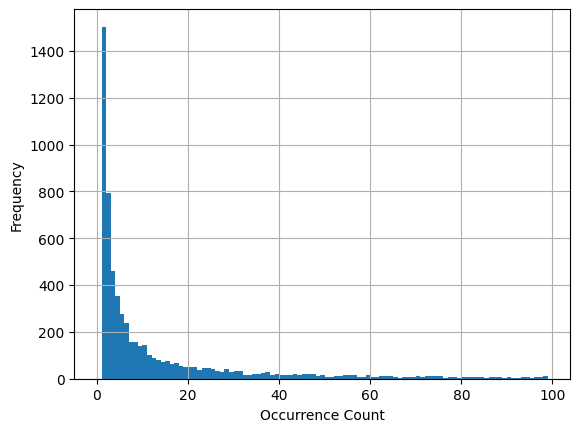

In [14]:
codes = pd.Series(dict(zip(mlb.classes_, np.sum(y, axis=0))))
ax = codes.hist(bins=np.arange(0,100, 1))
ax.set_xlabel('Occurrence Count')
ax.set_ylabel('Frequency')

As you can see many codes have 20 or less examples, to speed up training we will ignore codes that occur less than 50 times. 

The authors of the DeepLabeler trained a model to handle labeling all codes, but when there is less than 50 positive cases you are going to have a very small training set. We will now remove all codes that occur less than 50 times, when we do a test/train split of 80/20 we will have on average 10 test samples. 

In [15]:
valid_codes = codes[codes > 50].index.to_list()
len(valid_codes)

1292

In [16]:
valid_codes = codes[codes > 50].index.to_list()
diag = diag_raw[diag_raw['ICD9_CODE'].notna() & diag_raw['ICD9_CODE'].isin(valid_codes)]
diag.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [17]:
diag = diag.groupby(['SUBJECT_ID', 'HADM_ID'])['ICD9_CODE'].progress_apply(lambda x: list(x)).reset_index()
diag.head()

100%|██████████| 58796/58796 [00:01<00:00, 33270.20it/s]


,SUBJECT_ID,HADM_ID,ICD9_CODE
0,2,163353,"[V3001, V053, V290]"
1,3,145834,"[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
2,4,185777,"[042, 1363, 7994, 2763, 7907, 5715, 04111, V090]"
3,5,178980,"[V3000, V053, V290]"
4,6,107064,"[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."


In [18]:
final = discharges.merge(diag, left_on=['SUBJECT_ID', 'HADM_ID'], right_on=['SUBJECT_ID', 'HADM_ID'], how='inner')
print(final.shape)
final.head()

(52622, 5)


,SUBJECT_ID,HADM_ID,TEXT,toks,ICD9_CODE
0,3,145834.0,sex m service medicine chief complaint admitt...,"[sex, m, service, medicine, chief, complaint, ...","[0389, 78559, 5849, 4275, 41071, 4280, 6826, 4..."
1,4,185777.0,sex f service chief complaint shortness of br...,"[sex, f, service, chief, complaint, shortness,...","[042, 1363, 7994, 2763, 7907, 5715, 04111, V090]"
2,6,107064.0,sex f service admission diagnosis end stage r...,"[sex, f, service, admission, diagnosis, end, s...","[40391, 4440, 9972, 2766, 2767, 2859, 2753, V1..."
3,9,150750.0,sex m service neurology chief complaint weakn...,"[sex, m, service, neurology, chief, complaint,...","[431, 5070, 4280, 5849, 2765, 4019]"
4,10,184167.0,sex f service history of present illness baby...,"[sex, f, service, history, of, present, illnes...","[V3000, 7742, 76525, 76515, V290]"


In [19]:
final.to_parquet('prepared-data.pq')

<Axes: >

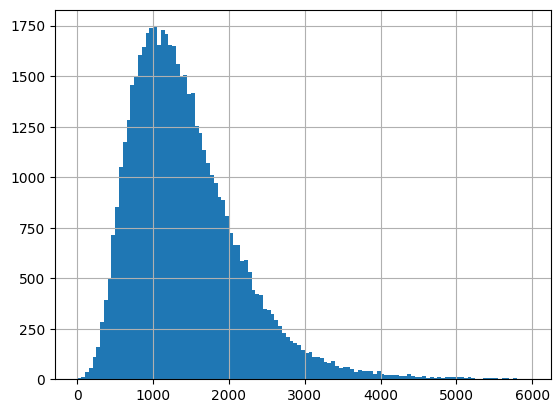

In [20]:
final.toks.str.len().hist(bins= np.arange(0, 6000, 50))

In [21]:
end = datetime.now()
total_time = end - start
total_time

datetime.timedelta(seconds=118, microseconds=715848)